In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis = 0)
train_data = shuffle(train_data, random_state = 42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

noise_all = pd.concat([noise_real, noise_syn], axis = 0)

scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, Bidirectional, GRU,
                                     GlobalAveragePooling1D, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def build_cnn_bigru(input_shape=(16384, 1),
                    conv_filters=(32, 64, 128),
                    kernels=(15, 9, 7),
                    pools=(4, 4, 4),
                    rnn_units=64,
                    dropout=0.3,
                    lr=3e-4):
    inp = Input(shape=input_shape)
    x = inp

    # ----- CNN feature extractor -----
    for f, k, p in zip(conv_filters, kernels, pools):
        x = Conv1D(f, k, padding="same")(x)
        x = BatchNormalization()(x)      
        x = ReLU()(x)
        x = MaxPooling1D(pool_size=p)(x)
        x = Dropout(0.1)(x)

    # ----- Bidirectional GRU -----
    x = Bidirectional(GRU(rnn_units, return_sequences=True))(x)
    x = BatchNormalization()(x)          
    x = GlobalAveragePooling1D()(x)      
    x = Dropout(dropout)(x)

    # ----- Output layer -----
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build and train
cnn_bigru = build_cnn_bigru()
history = cnn_bigru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_plateau],
    verbose=1
)

# Predictions
y_pred = cnn_bigru.predict(X_val).ravel()


Epoch 1/30
448/448 [==============================] - 40s 80ms/step - loss: 0.7333 - accuracy: 0.5170 - auc: 0.5185 - val_loss: 0.7655 - val_accuracy: 0.5006 - val_auc: 0.5887 - lr: 3.0000e-04
Epoch 2/30
448/448 [==============================] - 38s 85ms/step - loss: 0.6979 - accuracy: 0.5346 - auc: 0.5486 - val_loss: 0.6880 - val_accuracy: 0.5165 - val_auc: 0.6850 - lr: 3.0000e-04
Epoch 3/30
448/448 [==============================] - 46s 102ms/step - loss: 0.5514 - accuracy: 0.6987 - auc: 0.7808 - val_loss: 0.4925 - val_accuracy: 0.7372 - val_auc: 0.8573 - lr: 3.0000e-04
Epoch 4/30
448/448 [==============================] - 47s 105ms/step - loss: 0.4165 - accuracy: 0.7619 - auc: 0.8768 - val_loss: 0.4148 - val_accuracy: 0.7737 - val_auc: 0.8950 - lr: 3.0000e-04
Epoch 5/30
448/448 [==============================] - 49s 109ms/step - loss: 0.3864 - accuracy: 0.7834 - auc: 0.8935 - val_loss: 0.4111 - val_accuracy: 0.7785 - val_auc: 0.8992 - lr: 3.0000e-04
Epoch 6/30
448/448 [============

ROC AUC Score: 0.9306914660395409
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84      1792
         1.0       0.89      0.76      0.82      1792

    accuracy                           0.83      3584
   macro avg       0.84      0.83      0.83      3584
weighted avg       0.84      0.83      0.83      3584



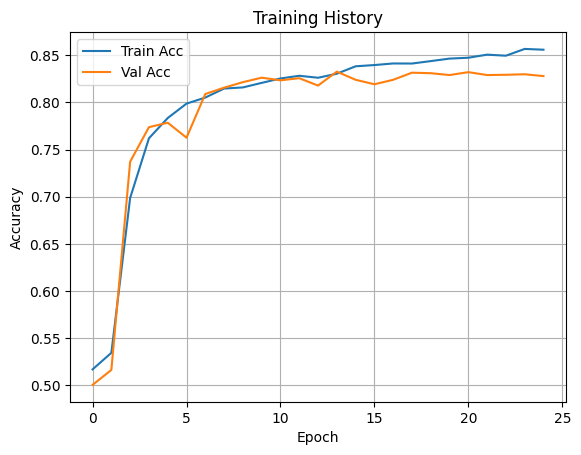

In [5]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [7]:
cnn_bigru.save("final_combined_cnn_gru_model.h5")